In [134]:
import pandas as pd
import numpy as np
from math import exp
from random import seed , random
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# **Question 1**

In [135]:
data = pd.read_csv('/content/wheat-seeds.csv',delimiter=',')
data

,15.26,14.84,0.871,5.763,3.312,2.221,5.22,1
0,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
1,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
2,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
3,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
4,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1
...,...,...,...,...,...,...,...,...
204,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
205,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
206,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
207,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


We are going to make use of these 7 features
1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove

In [136]:
#converting the dataframe as per the names
df = pd.DataFrame(data)
df.columns =['Area','Perimeter','Compactness','Kernel-Length','Kernel-Width','Asymmetry-Coefficient','Kernel-Grove','Type']
df

,Area,Perimeter,Compactness,Kernel-Length,Kernel-Width,Asymmetry-Coefficient,Kernel-Grove,Type
0,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
1,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
2,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
3,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
4,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1
...,...,...,...,...,...,...,...,...
204,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
205,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
206,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
207,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


**DISTRIBUTION OF DATASET** 

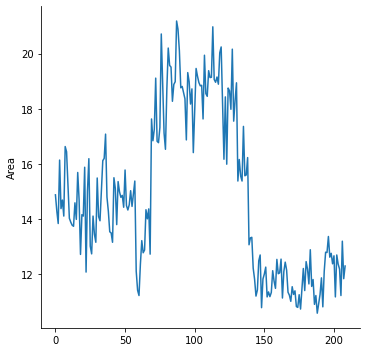

In [137]:
#not a good way seeems here to visualise the dataset
sns.relplot( kind='line', data=df['Area'])

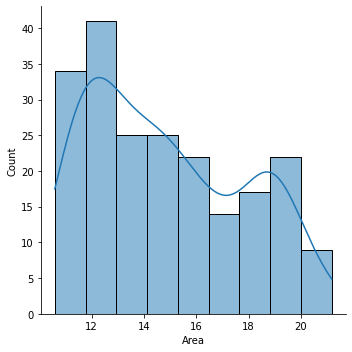

In [138]:
sns.displot(df['Area'],kde=True)

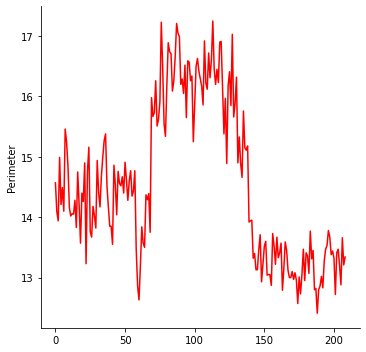

In [139]:
sns.relplot( kind='line', data=df['Perimeter'],color='r')

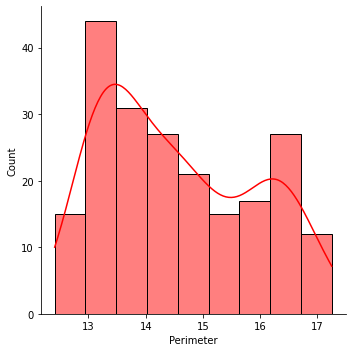

In [140]:
sns.displot(df['Perimeter'],kde=True,color='r')

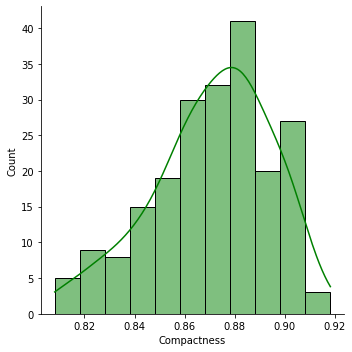

In [141]:
sns.displot(df['Compactness'],kde=True,color='g')

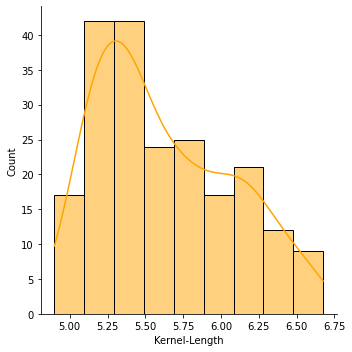

In [142]:
sns.displot(df['Kernel-Length'],kde=True,color='orange')

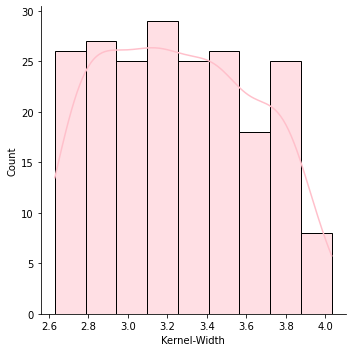

In [143]:
sns.displot(df['Kernel-Width'],kde=True,color='pink')

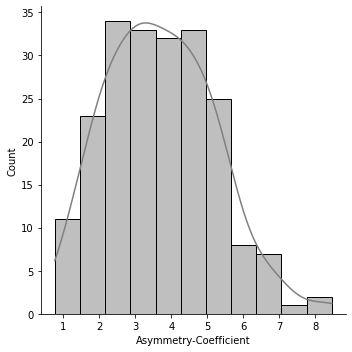

In [144]:
sns.displot(df['Asymmetry-Coefficient'],kde=True,color='gray')

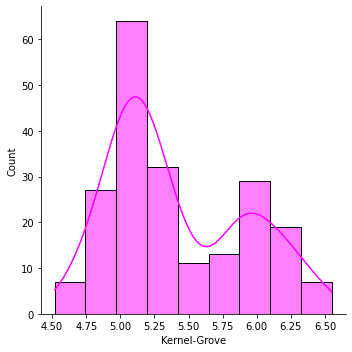

In [145]:
sns.displot(df['Kernel-Grove'],kde=True,color='magenta')

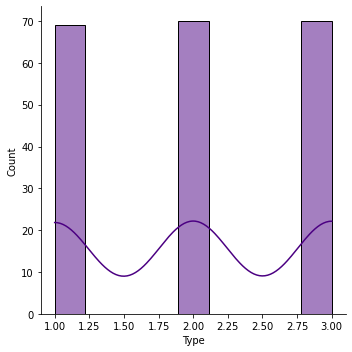

In [146]:
sns.displot(df['Type'],kde=True,color='indigo')

In [147]:
#seperation of independent and dependent variables
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

splits = []
for i in range(1,100):
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = i/100,shuffle = True)
  splits.append([X_train,X_test,y_train,y_test])

### **Multi-Layered Perceptron (Scratch Implementation)**


INITIALIZE WEIGHTS


In [148]:
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network


NEURON ACTIVATION FUNCTION

In [149]:
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

TRANSFER FUNCTION FOR NEURON ACTIVATION

In [150]:
def sigmoid(activation):
	return 1.0 / (1.0 + exp(-activation))
 
def relu(activation):
  return max(0,activation)

FORWARD PROPAGATION

In [151]:
def forward_propagate(network, row, activation = 'relu'):
  inputs = row
  for layer in network:
    new_inputs = []
    for neuron in layer:
      active = activate(neuron['weights'], inputs)
      if activation == 'relu':
        neuron['output'] = relu(active)
      else:
        neuron['output'] = sigmoid(active)
      new_inputs.append(neuron['output'])
    inputs = new_inputs
  return inputs

DERIVATIVE OF A NEURON OUTPUT

In [152]:
def sigmoid_derivative(output):
	return output * (1.0 - output)
 
def relu_derivative(output):
  if output>0:
    return 1
  else:
    return 0

BACKPROPAGATION ALGORITHM FOR ERRORS

In [153]:
def backward_propagate_error(network, expected,activation = 'relu'):
  for i in reversed(range(len(network))):
    layer = network[i]
    errors = list()
    if i!= len(network)-1:
      for j in range(len(layer)):
        error = 0.0
        for neuron in network[i+1]:
          error += (neuron['weights'][j] * neuron['delta'])
        errors.append(error)
    else:
      for j in range(len(layer)):
        neuron = layer[j]
        errors.append(expected[j] - neuron['output'])
    for j in range(len(layer)):
      neuron = layer[j]
      if activation == 'relu':
        neuron['delta'] = errors[j] * relu_derivative(neuron['output'])
      else:
        neuron['delta'] = errors[j] * sigmoid_derivative(neuron['output'])

NETWORK WEIGHTS UPDATE

In [154]:
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += l_rate * neuron['delta']

TRAIN NETWORK FOR FIXED NO OF EPOCHS

In [155]:
def train_network(network, train, l_rate, n_epoch, n_outputs,activation = 'relu'):
  loss = []
  for epoch in range(n_epoch):
    sum_error = 0
    for row in train:
      outputs = forward_propagate(network,row,activation)
      for j in range(len(outputs)):
        if outputs[j]!= max(outputs):
          outputs[j] = 0
        else:
          outputs[j] = 1
      expected = [0 for i in range(n_outputs)]
      expected[int(row[-1])-1] = 1
      sum_error += sum([(expected[ii]-outputs[ii])**2 for ii in range(0,len(expected))])
      backward_propagate_error(network, expected,activation)
      update_weights(network,row,l_rate)
    loss.append(sum_error)
  return min(loss)/len(train)

PREDICTION MAKING

In [156]:
def predict(network, test):
  pred=[]
  for row in test:
    outputs = forward_propagate(network,row)
    pred.append(outputs.index(max(outputs))+1)
  return pred

TESTING ON WHEATS SEEDS DATASET

In [167]:
seed()
network_1 = initialize_network(X.shape[1],1,3)
scores_s_1 = []
best_loss_s_1 = []
for i in range(len(splits)):
  training = np.column_stack((splits[i][0],splits[i][2])).tolist()
  test = np.column_stack((splits[i][1],splits[i][3]))
  loss_1 = train_network(network_1,training,0.001,1000,3,'sigmoid')
  pred_1 = predict(network_1,test)
  scores_s_1.append(accuracy_score(test[:,-1],pred_1))
  best_loss_s_1.append(loss_1)
test

array([[11.27  , 12.97  ,  0.8419, ...,  4.309 ,  5.    ,  3.    ],
       [19.06  , 16.45  ,  0.8854, ...,  2.248 ,  6.163 ,  2.    ],
       [18.88  , 16.26  ,  0.8969, ...,  1.649 ,  6.109 ,  2.    ],
       ...,
       [18.43  , 15.97  ,  0.9077, ...,  2.984 ,  5.905 ,  2.    ],
       [12.46  , 13.41  ,  0.8706, ...,  4.987 ,  5.147 ,  3.    ],
       [11.4   , 13.08  ,  0.8375, ...,  5.588 ,  5.089 ,  3.    ]])

In [168]:
training

[[12.44, 13.59, 0.8462, 5.319, 2.897, 4.9239999999999995, 5.27, 3.0],
 [15.69, 14.75, 0.9058, 5.527, 3.514, 1.599, 5.046, 1.0]]

### **EXTRA ANALYSIS (PREDICTION USING RELU FUNCTION)**

In [174]:
seed()
network_2 = initialize_network(X.shape[1],1,3)
scores_s_2 = []
best_loss_s_2 = []
for i in range(len(splits)):
  training = np.column_stack((splits[i][0],splits[i][2])).tolist()
  test = np.column_stack((splits[i][1],splits[i][3]))
  loss_2 = train_network(network_2,training,0.001,1000,3,'relu')
  pred_2 = predict(network_2,test)
  scores_s_2.append(accuracy_score(test[:,-1],pred_2))
  best_loss_s_2.append(loss_2)

In [175]:
comp_scores = pd.DataFrame(scores_s_1)
comp_scores.columns = ['SCORES_MODEL1']
comp_scores['SCORES_MODEL2'] = list(scores_s_2)
comp_scores


,SCORES_MODEL1,SCORES_MODEL2
0,0.333333,0.000000
1,0.400000,0.200000
2,0.428571,0.000000
3,0.333333,0.333333
4,0.272727,0.272727
...,...,...
94,0.336683,0.326633
95,0.333333,0.333333
96,0.325123,0.325123
97,0.326829,0.326829


In [176]:
comp_loss = pd.DataFrame(best_loss_s_1)
comp_loss.columns = ['BESTLOSS_MODEL1']
comp_loss['BESTLOSS_MODEL2'] = list(best_loss_s_2)
comp_loss

,BESTLOSS_MODEL1,BESTLOSS_MODEL2
0,1.320388,1.320388
1,1.323529,1.323529
2,1.306931,1.306931
3,1.330000,1.330000
4,1.323232,1.343434
...,...,...
94,1.000000,1.000000
95,1.250000,1.250000
96,0.666667,0.666667
97,1.500000,1.000000


### **Multi-Layered Perceptron (Sklearn's Implementation)**

In [177]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

scores_sk_1 = []
best_loss_sk_1 = []
for j in range(len(splits)):
  model_1 = MLPClassifier(solver='sgd',nesterovs_momentum=False,max_iter=1000,learning_rate_init=0.001,hidden_layer_sizes=(7,),activation='relu',alpha = 0,power_t = 0,momentum=0)
  model_1.fit(splits[j][0],splits[j][2])
  scores_sk_1.append(model_1.score(splits[j][1],splits[j][3]))
  best_loss_sk_1.append(model_1.best_loss_)

In [178]:
scores_sk_2 = []
best_loss_sk_2 = []
for j in range(len(splits)):
  model_2 = MLPClassifier(solver='sgd',nesterovs_momentum=False,max_iter=1000,learning_rate_init=0.001,hidden_layer_sizes=(7,),activation='relu',alpha = 0,power_t = 0,momentum=0)
  model_2.fit(splits[j][0],splits[j][2])
  scores_sk_2.append(model_2.score(splits[j][1],splits[j][3]))
  best_loss_sk_2.append(model_2.best_loss_)

In [179]:
comp_scores_sk = pd.DataFrame(scores_sk_1)
comp_scores_sk.columns = ['SCORES_MODEL1_SK']
comp_scores_sk['SCORES_MODEL2_SK'] = list(scores_sk_2)
comp_scores_sk

,SCORES_MODEL1_SK,SCORES_MODEL2_SK
0,0.666667,1.000000
1,0.800000,1.000000
2,0.714286,0.285714
3,0.333333,0.888889
4,0.454545,0.272727
...,...,...
94,0.326633,0.643216
95,0.567164,0.756219
96,0.330049,0.433498
97,0.619512,0.356098


In [180]:
comp_loss_sk = pd.DataFrame(best_loss_sk_1)
comp_loss_sk.columns = ['BESTLOSS_MODEL1_SK']
comp_loss_sk['BESTLOSS_MODEL2_SK'] = list(best_loss_sk_2)
comp_loss_sk

,BESTLOSS_MODEL1_SK,BESTLOSS_MODEL2_SK
0,0.623146,0.672025
1,0.599256,0.543548
2,0.863372,0.739258
3,0.999291,0.632163
4,0.900111,0.948005
...,...,...
94,0.938005,0.570853
95,0.460780,0.528168
96,0.654297,0.460418
97,0.665763,0.956167


In [183]:
total_scores = pd.concat([comp_scores,comp_scores_sk],axis=1)
total_scores

,SCORES_MODEL1,SCORES_MODEL2,SCORES_MODEL1_SK,SCORES_MODEL2_SK
0,0.333333,0.000000,0.666667,1.000000
1,0.400000,0.200000,0.800000,1.000000
2,0.428571,0.000000,0.714286,0.285714
3,0.333333,0.333333,0.333333,0.888889
4,0.272727,0.272727,0.454545,0.272727
...,...,...,...,...
94,0.336683,0.326633,0.326633,0.643216
95,0.333333,0.333333,0.567164,0.756219
96,0.325123,0.325123,0.330049,0.433498
97,0.326829,0.326829,0.619512,0.356098


In [184]:
total_best_loss = pd.concat([comp_loss,comp_loss_sk],axis=1)
total_best_loss

,BESTLOSS_MODEL1,BESTLOSS_MODEL2,BESTLOSS_MODEL1_SK,BESTLOSS_MODEL2_SK
0,1.320388,1.320388,0.623146,0.672025
1,1.323529,1.323529,0.599256,0.543548
2,1.306931,1.306931,0.863372,0.739258
3,1.330000,1.330000,0.999291,0.632163
4,1.323232,1.343434,0.900111,0.948005
...,...,...,...,...
94,1.000000,1.000000,0.938005,0.570853
95,1.250000,1.250000,0.460780,0.528168
96,0.666667,0.666667,0.654297,0.460418
97,1.500000,1.000000,0.665763,0.956167


### **EXTRA ANALYSIS (COMPARISON USING BOXPLOTS,LINEPLOTS)**

**COMPARING SCRATCH MODELS SCORES[USING SIGMOID(MODEL 1) AND RELU(MODEL 2)]**

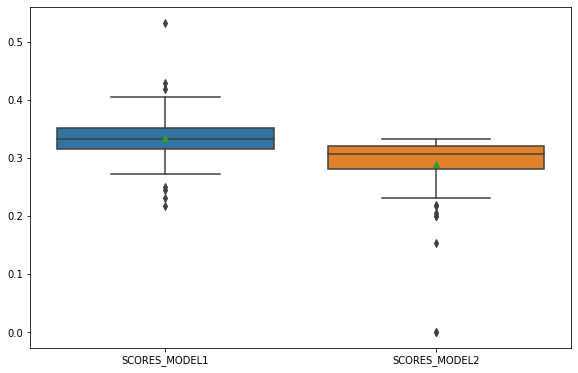

In [195]:
fig, ax = plt.subplots(figsize=(9.7, 6.27))
sns.boxplot(data=comp_scores,showmeans = True,ax=ax)

**COMPARING SKLEARN MODELS SCORES[USING SIGMOID(MODEL 1) AND RELU(MODEL 2)]**

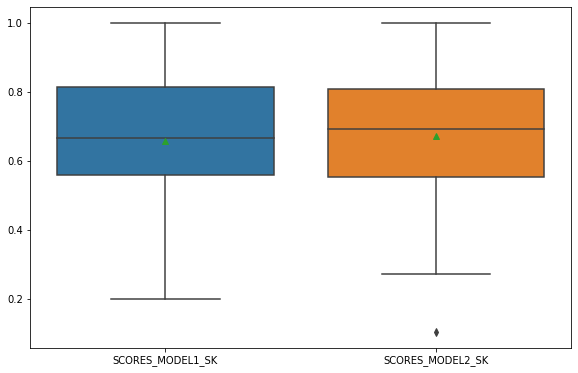

In [196]:
fig, ax = plt.subplots(figsize=(9.7, 6.27))
sns.boxplot(data=comp_scores_sk,showmeans = True,ax=ax)

## **COMPARING BOTH SCRATCH AND SKLEARN MODELS SCORES([USING SIGMOID(MODEL 1) AND RELU(MODEL 2)]**

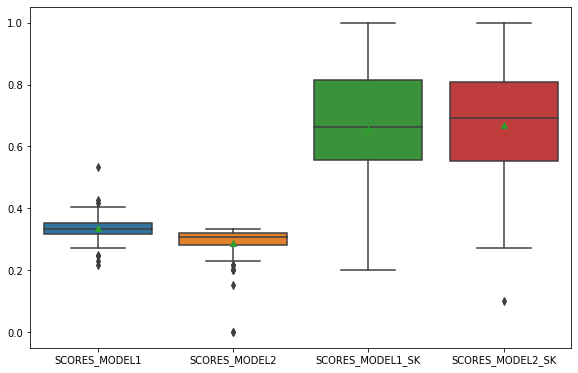

In [197]:
fig, ax = plt.subplots(figsize=(9.7, 6.27))
sns.boxplot(data=total_scores,showmeans = True,ax=ax)

**COMPARING SCRATCH MODELS LOSSES[USING SIGMOID(MODEL 1) AND RELU(MODEL 2)]**

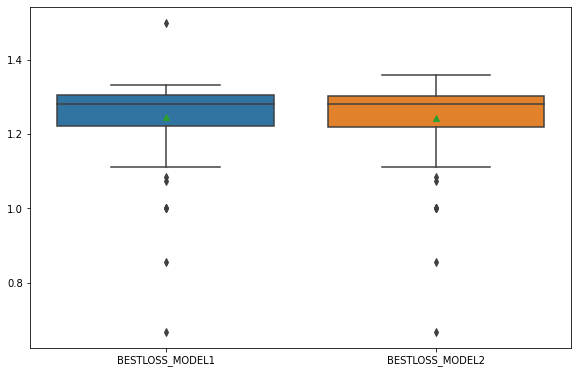

In [198]:
fig, ax = plt.subplots(figsize=(9.7, 6.27))
sns.boxplot(data=comp_loss,showmeans = True,ax=ax)

**COMPARING SKLEARN MODELS LOSSES[USING SIGMOID(MODEL 1) AND RELU(MODEL 2)]**

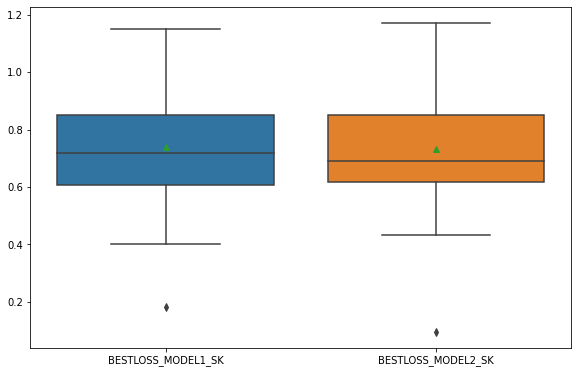

In [199]:
fig, ax = plt.subplots(figsize=(9.7, 6.27))
sns.boxplot(data=comp_loss_sk,showmeans = True,ax=ax)

## **COMPARING BOTH SCRATCH AND SKLEARN MODELS LOSSES([USING SIGMOID(MODEL 1) AND RELU(MODEL 2)]**

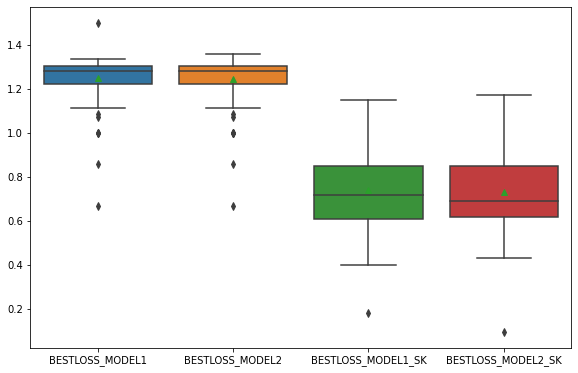

In [200]:
fig, ax = plt.subplots(figsize=(9.7, 6.27))
sns.boxplot(data=total_best_loss,showmeans = True,ax=ax)

**COMPARING SCRATCH AND SKLEARN MODELS LOSS USING LINEPLOTS(MODEL 1= SIGMOID AND MODEL 2= RELU)**

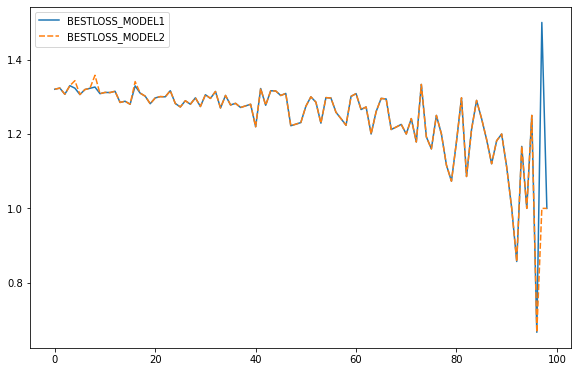

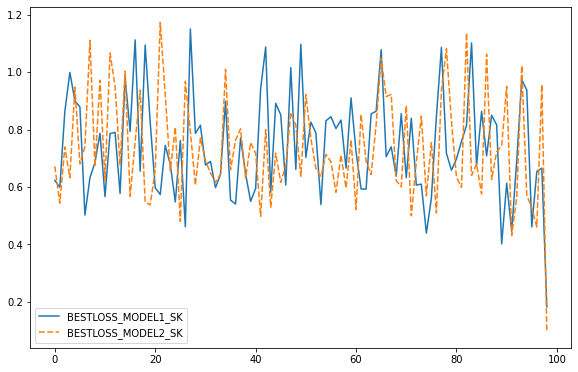

In [210]:
fig, ax = plt.subplots(figsize=(9.7, 6.27))
sns.lineplot(data=comp_loss,ax=ax)

fig, ax1 = plt.subplots(figsize=(9.7, 6.27))
sns.lineplot(data=comp_loss_sk,ax=ax1)

**COMPARING SCRATCH AND SKLEARN MODELS SCORES USING LINEPLOTS(MODEL 1= SIGMOID AND MODEL 2= RELU)**

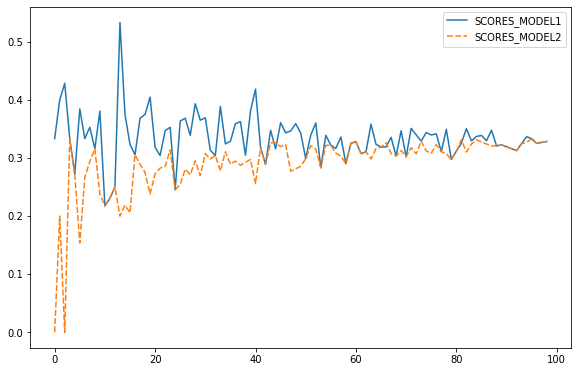

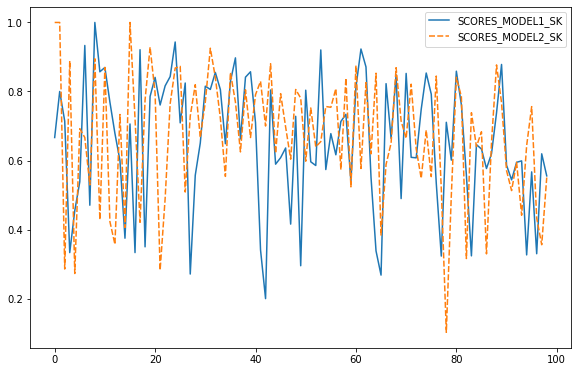

In [206]:
fig, ax = plt.subplots(figsize=(9.7, 6.27))
sns.lineplot(data=comp_scores,ax=ax)

fig, ax1 = plt.subplots(figsize=(9.7, 6.27))
sns.lineplot(data=comp_scores_sk,ax=ax1)